# Calibrating PKPD Model to AL TES Data from [Bassat et al., 2009](https://pubmed.ncbi.nlm.nih.gov/19936217/) and [Baraka et al., 2014](https://journals.asm.org/doi/10.1128/aac.03647-14)

## **Parameters**: 50k patients, 50 values of pmax_lum with EC50_lum, pmax_art and EC50_art at default values

## **Drug:** AL

### **Gene locus and Allele:** pfmdr1 N86

**Number of patients in arm:** 56

**Number of patients cured:** 49

**Efficacy:** 0.875 or 87.5%


### **Gene locus and Allele:** pfmdr1 86Y
**Number of patients in arm:** 35

**Number of patients cured:** 35

**Efficacy:** 1 or 100%


### **Gene locus and Allele:** pfcrt K76
**Number of patients in arm:** 27

**Number of patients cured:** 25

**Efficacy:** 0.9259 or 92.59%


### **Gene locus and Allele:** pfcrt 76T
**Number of patients in arm:** 62

**Number of patients cured:** 57

**Efficacy:** 0.9194 or 91.94%


<br>

In [3]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from timeit import default_timer as timer
from matplotlib.ticker import MaxNLocator
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count

In [4]:
# Define the range for pmax_art
min_pmax = 0.99997
max_pmax = 0.80001

# Define pmax_art values
pmax_values = np.linspace(min_pmax, max_pmax, 50)  # 30 values between 0.99997 and 0.8

# Initialize a grid to store the clearance rates
clearance_rates = np.zeros(len(pmax_values))

In [21]:
# Function to run a single simulation for a given pmax_art value
def run_simulation(idx, pmax):
    command_pmax_art_adj = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "100",
        "--pmax_art", str(pmax),
        "--pmax_lum", "0",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_art_adj = subprocess.run(command_pmax_art_adj, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_art_adj = output_pmax_art_adj.stdout.splitlines()
        df_pmax_art_adj = pd.DataFrame([line.split(',') for line in lines_pmax_art_adj], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_pmax_art_adj = df_pmax_art_adj.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_art_adj[(df_pmax_art_adj['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_pmax_art_adj['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_pmax_art_adj)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i]) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            idx, efficacy, df_pmax_art_adj = result
            results.append((idx, efficacy))
            if df_pmax_art_adj is not None:
                dfs.append(df_pmax_art_adj)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy in results:
    clearance_rates[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'pmax_art': pmax_values,
    'efficacy': clearance_rates
})

# Save the DataFrame to a pickle file
df.to_pickle("pkpd_AL_pmax_art_test_01_efficacy.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle("kpd_AL_pmax_art_test_01_results.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv("pkpd_AL_pmax_art_test_01_efficacy.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 50/50 [00:12<00:00,  3.92it/s]

DataFrame saved as pickle and CSV files successfully.


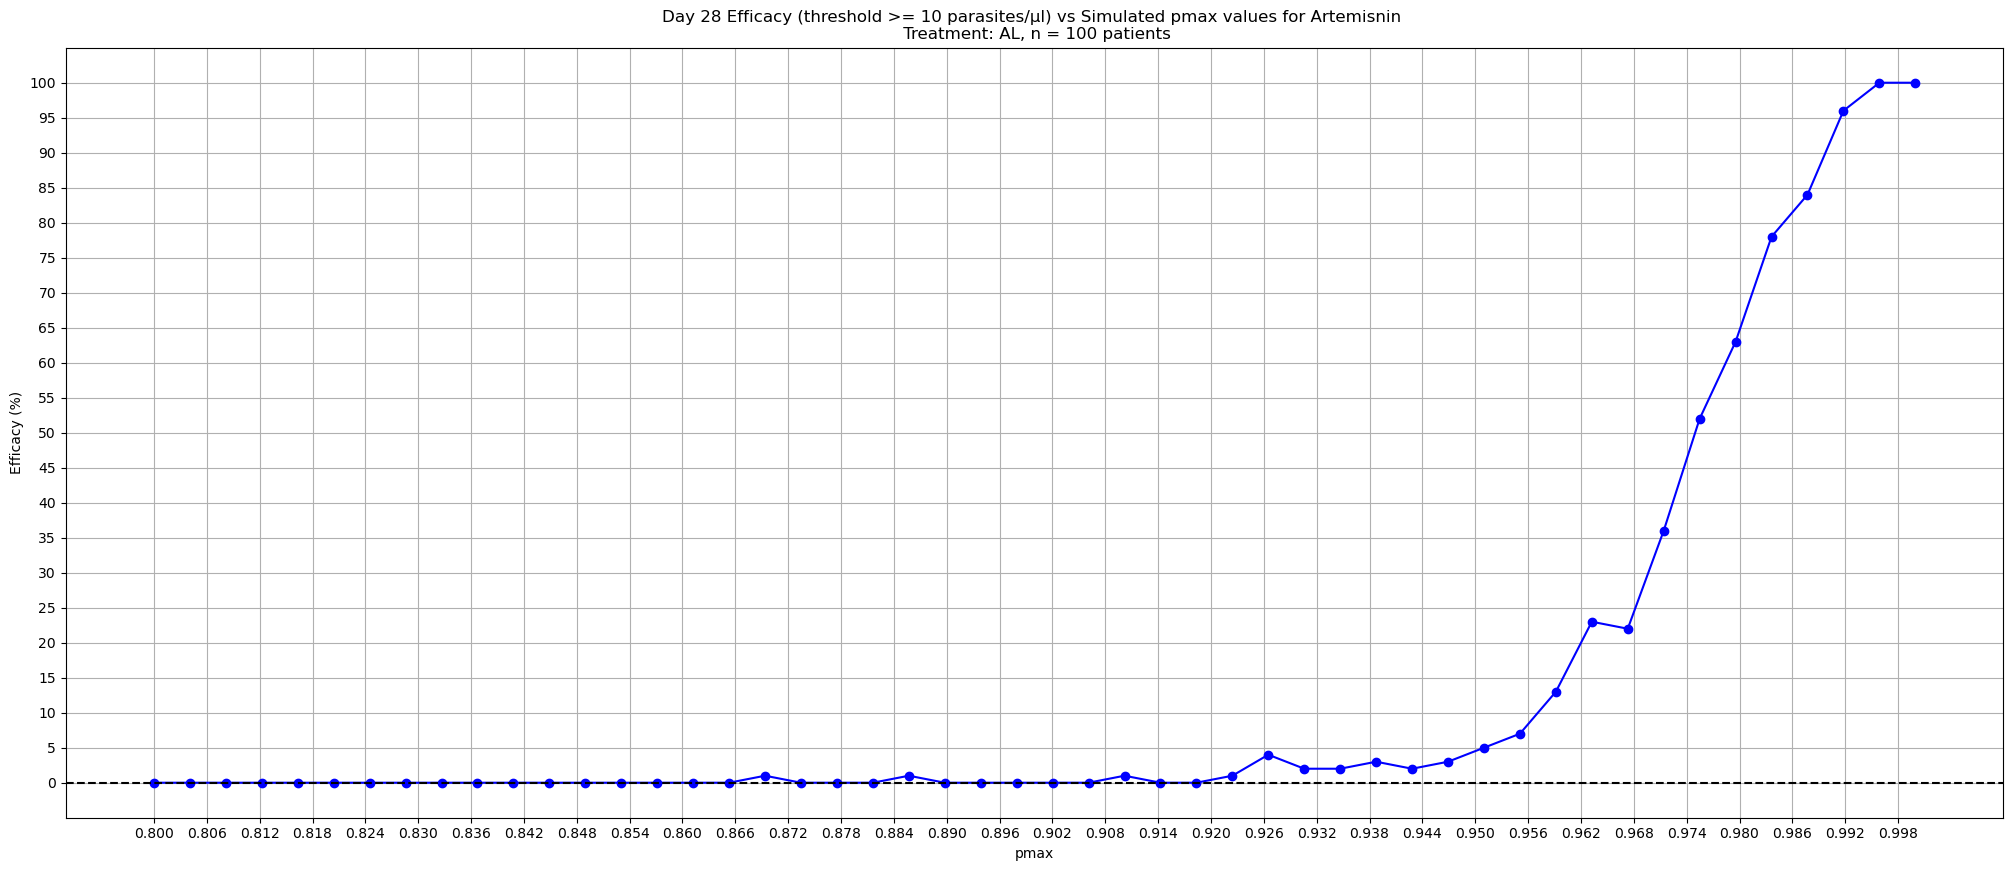

In [22]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, clearance_rates, marker='o', linestyle='-', color='b')
plt.xlabel('pmax')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Artemisnin \n Treatment: AL, n = 100 patients")
plt.grid(True)
plt.xticks(np.arange(min(pmax_values), max(pmax_values), 0.006))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_pmax_art_test_01_efficacy.png")  # Save the plot as a PNG file
plt.show()

## Repeating the same with 1k patients

In [23]:
# Function to run a single simulation for a given pmax_art value
def run_simulation(idx, pmax):
    command_pmax_art_adj = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "1000",
        "--pmax_art", str(pmax),
        "--pmax_lum", "0",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_art_adj = subprocess.run(command_pmax_art_adj, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_art_adj = output_pmax_art_adj.stdout.splitlines()
        df_pmax_art_adj = pd.DataFrame([line.split(',') for line in lines_pmax_art_adj], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_pmax_art_adj = df_pmax_art_adj.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_art_adj[(df_pmax_art_adj['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_pmax_art_adj['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_pmax_art_adj)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i]) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            idx, efficacy, df_pmax_art_adj = result
            results.append((idx, efficacy))
            if df_pmax_art_adj is not None:
                dfs.append(df_pmax_art_adj)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy in results:
    clearance_rates[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'pmax_art': pmax_values,
    'efficacy': clearance_rates
})

# Save the efficacy DataFrame to a pickle file
df.to_pickle("pkpd_AL_pmax_art_test_02_efficacy.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle("kpd_AL_pmax_art_test_02_results.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv("pkpd_AL_pmax_art_test_02_efficacy.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 50/50 [03:13<00:00,  3.87s/it]  

DataFrame saved as pickle and CSV files successfully.


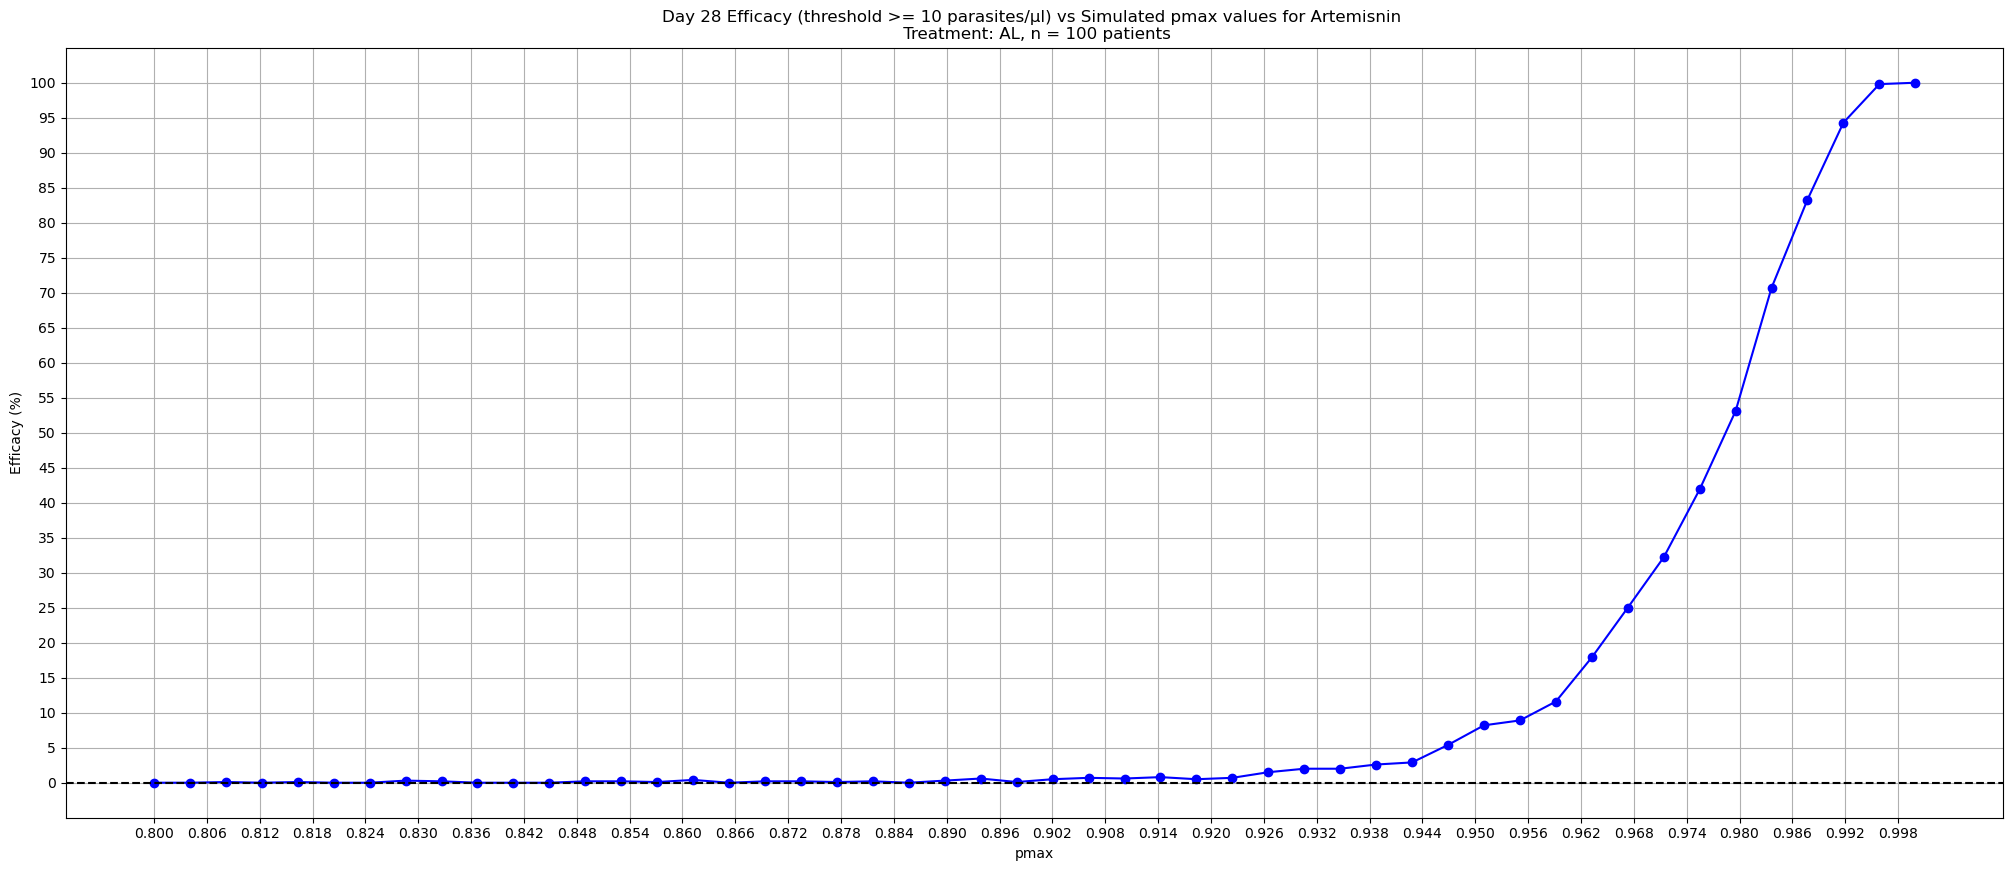

In [24]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, clearance_rates, marker='o', linestyle='-', color='b')
plt.xlabel('pmax')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Artemisnin \n Treatment: AL, n = 100 patients")
plt.grid(True)
plt.xticks(np.arange(min(pmax_values), max(pmax_values), 0.006))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_pmax_art_test_02_efficacy.png")  # Save the plot as a PNG file
plt.show()

In [28]:
df

,pmax_art,efficacy
0,0.999970,100.0
1,0.995889,99.8
2,0.991808,94.3
3,0.987728,83.3
4,0.983647,70.7
5,0.979566,53.1
6,0.975485,41.9
7,0.971404,32.2
8,0.967323,25.0
9,0.963243,17.9


In [29]:
dfs[49]

,PID,HOUR,COMP2CONC_ART,COMP2CONC_LUM,PARASITEDENSITY
1,0,671.0,0.0,115.681,31.884
2,1,671.0,0.0,120.676,30.070
3,2,671.0,0.0,145.021,27.473
4,3,671.0,0.0,112.267,32.117
5,4,671.0,0.0,155.228,29.619
...,...,...,...,...,...
996,995,671.0,0.0,114.949,30.590
997,996,671.0,0.0,115.999,33.189
998,997,671.0,0.0,109.054,26.578
999,998,671.0,-0.0,117.289,30.326


<Axes: ylabel='Frequency'>

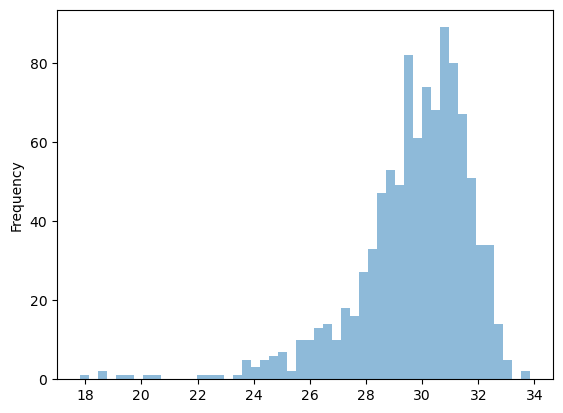

In [30]:
dfs[49]['PARASITEDENSITY'].plot.hist(bins=50, alpha=0.5)